In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import os
import linetools
from astropy.table import Table
import astropy
from astropy.io import ascii
c_in_km_s = astropy.constants.c.to('km/s').value

import VoigtFit # the warning about line 1 being empty can be ignored 
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

from voigtfit_mod import * 

from astropy.io import fits

/Users/hbish/anaconda3/envs/voigtfit/lib/python3.12/site-packages/VoigtFit/utils/Asplund.py:19: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  Lodders2009 = np.loadtxt(fname, usecols=(1, 2), dtype=str)


In [2]:
%reload_ext voigtfit_mod

In [3]:
%reload_ext autoreload

# Part 1: Decide what target and ion you'd like to analyze 
You need to change <span style="color: red;font-weight: bold;">ion, spec_file, vel_min, and vel_max</span> 

In [431]:
ion = 'HI' 

# note: the code assumes that the spec file incl. WAVE, NORMFLUX, and NORMERR
# spec_file = 'data/sk-71d19/hlsp_ullyses_hst_cos_sk-71d19_g130m_dr7_cspec-si-iv.fits'
# spec_file = 'data/sk-70d115/hlsp_ullyses_hst_stis_sk-70d115_e140m_dr7_cspec-s-ii.fits'

# spec_file = 'data/TON1129/TON1129_ltnorm.fits'
# spec_file = 'data/SDSSJ095914.85+320357.2/SDSSJ095914.85+320357.2_ltnorm.fits'
# spec_file = 'data/FBQSJ095820.9+322402/FBQSJ095820.9+322402_ltnorm.fits'
# spec_file = 'data/2MASXJ12022678-0129155/2MASXJ12022678-0129155_ltnorm.fits'
# spec_file = 'data/SDSSJ120233.08+022559.7/SDSSJ120233.08+022559.7_ltnorm.fits'
# spec_file = 'data/SBS1421+511/SBS1421+511_ltnorm.fits'
# spec_file = 'data/SDSSJ142940.73+032125.8/SDSSJ142940.73+032125.8_ltnorm.fits'
# spec_file = 'data/2MASXJ14515156+5914001/2MASXJ14515156+5914001_ltnorm.fits'
spec_file = 'data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_ltnorm.fits'

# the velocity range you'd want to analyze, don't need to change much for ullyses target
fit_vmin = -400
fit_vmax = 400

# fit_vmin = -1000
# fit_vmax = 2000

# put in galaxy system velocity 
# gal_vsys = 0. # km/s, always zero for lmc analysis (MW frame), but can change for other target 
# z_sys = gal_vsys/c_in_km_s

# z_sys = 0.00486 # TON1129, FBQSJ095820.9+322402, SDSSJ095914.85+320357.2
# z_sys = 0.00487 # 2MASXJ12022678-0129155
# z_sys = 0.00656 # SDSSJ120233.08+022559.7
# z_sys = 0.0074 # SBS1421+511
# z_sys = 0.00552 # SDSSJ142940.73+032125.8 ****
z_sys = 0.00716 # 2MASXJ14515156+5914001
z_sys = 0.00932 # UVQSJ170043.71+223700.2

gal_vsys = z_sys*c_in_km_s

Decide instrument configuration and what lsf to use

In [432]:
# for ullyses target, this is taken care of
# otherwise you can comment the first two lines out, and put in config by hand 
instru = 'cos' #spec_file.split('/')[-1].split('_')[3]
grat = 'g130m' #spec_file.split('/')[-1].split('_')[5]
config = f'{instru}_{grat}'

default_lsf_file = {'stis_e140m': 'lsf/stis_lsf_e140m_0d2x0d2_yz.txt', 
                    'cos_g130m': 'lsf/cos_lsf_g130m_average_lp1-4_yz.txt', 
                    'cos_g160m': 'lsf/cos_lsf_g160m_average_lp1-4_yz.txt'
                   }
spec_res = default_lsf_file[config]
print(config, spec_res)

cos_g130m lsf/cos_lsf_g130m_average_lp1-4_yz.txt


In [433]:
# read in data, decide if binning is needed (only for cos), and decide which data to use 
# raw_spec = Table.read(spec_file, format='fits')
raw_spec = fits.open(spec_file)

if 'cos' in config: 
    npix = 1 # for cos, bin spec by 3 pixels to increase SNR 
    from voigtfit_mod import bin_spec
    bin_wave, bin_flux = bin_spec(raw_spec['WAVELENGTH'].data, raw_spec['FLUX'].data/raw_spec['CONTINUUM'].data, npix)
    _, bin_err = bin_spec(raw_spec['WAVELENGTH'].data, raw_spec['ERROR'].data/raw_spec['CONTINUUM'].data, npix)
    
    fit_spec = Table()
    fit_spec['wave'] = bin_wave
    fit_spec['flux'] = bin_flux
    fit_spec['err'] = bin_err
    print(f'You are using COS spectra, let\'s bin data by {npix} pixels')
else: 
    fit_spec = Table()
    fit_spec['wave'] = raw_spec['WAVE']
    fit_spec['flux'] = raw_spec['NORMFLUX']
    fit_spec['err'] = raw_spec['NORMERR']
    print('No binning was done, using spectrum at the original resolution')


You are using COS spectra, let's bin data by 1 pixels


In [434]:
# decide ion information 
# this is a pre-determined list of lines that we'd process
# ion_llist = {'SII': ["SII 1250", "SII 1253"], 
#              'SiIV': ["SiIV 1393", "SiIV 1402"] , 
#              'CIV': ["CIV 1548", "CIV 1550"]
#             }
ion_llist = {'HI': ["HI 1215"],
             'SiIV': ["SiIV 1393", "SiIV 1402"]
            }

## read atomic data from linetools 
line_list = ion_llist[ion]
from linetools.lists.linelist import LineList
llist_ism = LineList('ISM')._data.to_pandas()
llist_ism['species'] = llist_ism['name'].str.split().str[0]
line_info = llist_ism.query('(name in @line_list)').sort_values("f")
line_info = Table.from_pandas(line_info)
line_info

A,el,nj,nk,group,name,Ek,f,wrest,Ref,mol,Ej,Am,ion,Ex,Jj,Jk,Z,gk,gj,gamma,Id,species
float64,int64,int64,int64,int64,str7,float64,float64,float64,str10,bytes1,float64,int64,int64,float64,float64,float64,int64,int64,int64,float64,int64,str2
626500000.0,0,0,0,1,HI 1215,2259.163,0.4164,1215.67,Morton2003,--,0.0,0,1,0.0,0.0,0.0,1,6,2,626500000.0,268,HI


# Part 2: initial guesses on (v, b, logN) and how many velocity components 
In this part, the code will first plot a spectral line for you to examine. If you've already had a file with initial parameter guesses, it'll try to find it and read it in. But if you don't have one already, you'll put in the velocity ranges of the velocity components you identify in the cell below the figure

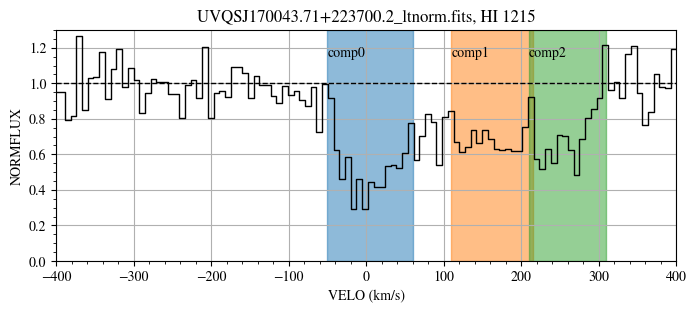

In [449]:
# let's check if there is an intial guess file with preset parameters already 
# by design, the initial guess has the same name as the input spectral line, just with extra suffix 
init_guess_file = spec_file.replace('_ltnorm.fits', '_init-guess.txt')
if os.path.isfile(init_guess_file) == True: 
    param_guess = Table.read(init_guess_file, format='ascii', header_start=0)
else:
    param_guess=None # just a holder, vcomps which be used later for plotting, don't change 

####################### plot spectra and decide how many velocity components 
iline = 0 # doesn't matter, just plot one line

spec_velo = (0 + (fit_spec['wave']-line_info['wrest'][iline])/line_info['wrest'][iline])*c_in_km_s-gal_vsys
plt.figure(figsize=(8, 3))
plt.plot(spec_velo, fit_spec['flux'], ds='steps-mid', color='k')
plt.axhline(1.0, ls='--', color='k', lw=1)
plt.xlim(fit_vmin, fit_vmax)
plt.ylim(0, 1.3)
plt.xlabel('VELO (km/s)')
plt.ylabel('NORMFLUX')
plt.minorticks_on()
plt.grid('on')
plt.title('%s, %s'%(spec_file.split('/')[-1], line_info['name'][iline]))

# this is color-coded each velocity component you identify, first run will always be blank 
if param_guess != None: 
    for i in range(len(param_guess)):  
        plt.axvspan(param_guess['vmin'][i], param_guess['vmax'][i], color=plt.cm.tab10(i/10.), alpha=0.5)
        plt.text(param_guess['vmin'][i], 1.15, 'comp%s'%param_guess['comp'][i])

If you haven't done any initial parameter guesses, <span style="color: red;font-weight: bold;">based on the spectrum above, decide how many velocity components</span>, and record the left and right bounds of the velocity components in the list vcomps below. The most important thing is to guess how many velocity components you want to put down and the rough velocity bounds for each component <br>

In [450]:
overwrite_init_guess_file = False # only set to true if you want to overwrite a pre existing initial guess file

In [459]:
if (os.path.isfile(init_guess_file) == True) & (overwrite_init_guess_file==False): 
    param_guess = Table.read(init_guess_file, format='ascii', header_start=0)
    print('Initial guess param file already exists, reading from ', init_guess_file)
else:

    # # TON1129
    # vcomps = [[-120., -68.],
    #           [ -70.,  12.],
    #           [  12.,  88.], 
    #           [  55.,  85.],
    #           [  85., 145.],
    #           [ 145., 230.],
    #           [ 235., 305.]]

    # # SDSSJ095914.85+320357.2
    # vcomps = [[-30., 300.],#[-30., 130.],
    #           [-60., -30.],
    #           [-90., -60.]]

    # # FBQSJ095820.9+322402
    # vcomps = [[-500., 2000.]]

    # # 2MASXJ12022678-0129155
    # vcomps = [[-15., 95.]]

    # # SDSSJ120233.08+022559.7
    # vcomps = [[-40., 40.],
    #           [ 40.,120.],
    #          [-100.,-40.]]

    # # SBS1421+511
    # vcomps = [[  -50., 130.],
    #           [ -240.,-150.]]

    # # SDSSJ142940.73+032125.8
    # vcomps = [[ -250., 50.],
    #           [  100.,185.]]
    
    # 2MASXJ14515156+5914001
    vcomps = [[ -110., 85.],
              [85.,110.]]

    # UVQSJ170043.71+223700.2
    vcomps = [[-50., 60.],
              [110.,215.],
             [ 210.,310.]]
    
    from voigtfit_mod import estimate_inti_guess_params
    input_spec = [fit_spec['wave'], fit_spec['flux'], fit_spec['err']] #np.abs(fit_spec['err'])
    param_guess = estimate_inti_guess_params(vcomps, line_info, input_spec, [fit_vmin, fit_vmax], init_guess_file)

param_guess

Initial guess param file already exists, reading from  data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_init-guess.txt


comp,vmin,vmax,z,v,b,logN
int64,float64,float64,float64,float64,float64,float64
0,-50.0,60.0,0.00931,0.0,25.0,13.63
1,110.0,215.0,0.00983,135.0,10.0,12.738
2,210.0,310.0,0.0101,270.0,10.0,13.195


<span style="color: red;font-weight: bold;">After you run the cell above, go back and run the previous cell, it'll plot out all components you've guessed</span>. Decide if you like these components, if not, tweak the vcomps velocity bound and run again; if you are happy with the initial guesses, proceed to Part 3

# Part 3: Fit Voigt profiles with param_guess as initial inputs

In [460]:
%reload_ext voigtfit_mod

In [461]:
param_guess

comp,vmin,vmax,z,v,b,logN
int64,float64,float64,float64,float64,float64,float64
0,-50.0,60.0,0.00931,0.0,25.0,13.63
1,110.0,215.0,0.00983,135.0,10.0,12.738
2,210.0,310.0,0.0101,270.0,10.0,13.195



 [DONE] - Continuum fitting successfully finished.



 [WARNING]  -  Check-lines is activated
 The following lines of included ions are also covered by the data:

          HI_1 :  f = 4.16e-01



  Dataset is ready to be fitted.


  Fit is running... Please be patient.


 The fit has finished with the following exit message:
  Fit succeeded.


----------------------
  Best fit parameters:
----------------------

				b			log(N)
HI  1215
v =  +1.2 ± 4.4             21.37 ±  14.53      14.2357 ±  0.7204
v = +146.9 ± 39.2             82.10 ±  81.69      13.6960 ±  0.3316
v = +250.3 ± 10.0             19.63 ±  32.65      13.5208 ±  0.3182


<Parameter 'z0_HI', value=np.float64(0.009323950356004864) +/- 1.48e-05, bounds=[-inf:inf]>
1.4766509847692955e-05
<Parameter 'z1_HI', value=np.float64(0.009814523848462799) +/- 0.000132, bounds=[-inf:inf]>
0.0001320928476983682
<Parameter 'z2_HI', value=np.float64(0.010162680101800214) +/- 3.38e-05, bounds=[-inf:inf]>
3.375920233000477e-05
Saving best

comp,ion,z,z_e,b,b_e,logN,logN_e,v,v_e
str5,str2,float64,float64,float64,float64,float64,float64,float64,float64
comp0,HI,0.009324,1.5e-05,21.37,14.53,14.24,0.72,1.2,4.5
comp1,HI,0.009815,0.000132,82.1,81.69,13.7,0.33,148.4,39.57
comp2,HI,0.010163,3.4e-05,19.63,32.65,13.52,0.32,252.73,10.19


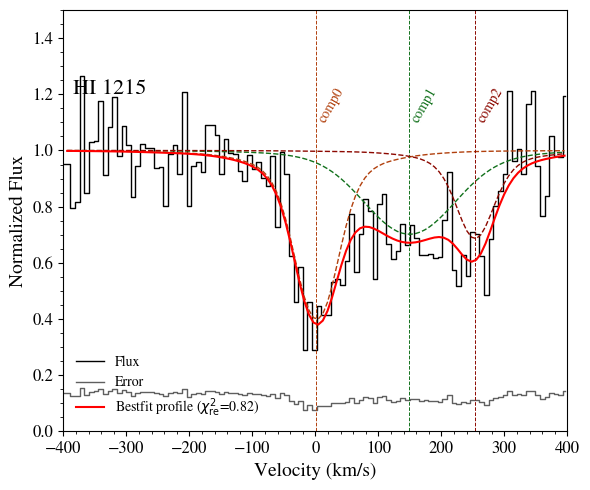

In [462]:
### initialize fitting, add data, and add lines
dataset = VoigtFit.DataSet(z_sys) 
dataset.add_data(fit_spec['wave'], fit_spec['flux'], spec_res, err=fit_spec['err'], normalized=True)
for iline in range(len(line_info)): 
    line_name = line_info['name'][iline].replace(' ', '_')
    dataset.add_line(line_name)

### add velocity components based on initial guesses 
input_tb = param_guess.copy()
for i in range(len(input_tb)): 
    dataset.add_component(ion, input_tb['z'][i], input_tb['b'][i], input_tb['logN'][i])

# Crucial step, prepare dataset, Run the fit:
dataset.prepare_dataset(verbose=True)
popt, chi2 = dataset.fit(verbose=True)
# dataset.plot_fit()

# record the result and plot individual components
figname = spec_file.replace('_ltnorm.fits', '_vfit.pdf')
tbname = spec_file.replace('_ltnorm.fits', '_vfit-param.txt')

# from voigtfit_mod import reproduce_individual_voigt_profile
param_bestfit = parse_output_to_astropy_table(ion, dataset.best_fit, popt, tbname=tbname, z_sys=z_sys)

if len(param_guess) == 1: voigt_files = reproduce_voigt_profile(line_info, param_bestfit[:], fit_spec['wave'], spec_res, spec_file, z_sys=z_sys)
else: voigt_files = reproduce_voigt_profile(line_info, param_bestfit[:], fit_spec['wave'], spec_res, spec_file, z_sys=z_sys)
plot_fit_result(line_info, voigt_files, fit_spec, param_bestfit, vmin=fit_vmin, vmax=fit_vmax,gal_vsys=gal_vsys,figname=figname)
param_bestfit

In [463]:
popt

In [464]:
dataset.best_fit

name,value,standard error,relative error,initial value,min,max,vary
sid_a8aa15_dvel,0.00000000,0.00000000,,0.0,-inf,inf,False
sid_a8aa15_dlam,0.00000000,0.00000000,,0.0,-5.00000000,5.00000000,False
z0_HI,0.00932395,1.4767e-05,(0.16%),0.00931,-inf,inf,True
b0_HI,21.3687868,14.5257933,(67.98%),25.0,0.00000000,inf,True
logN0_HI,14.2356691,0.72038103,(5.06%),13.63,-inf,inf,True
z1_HI,0.00981452,1.3209e-04,(1.35%),0.00983,-inf,inf,True
b1_HI,82.0963505,81.6889937,(99.50%),10.0,0.00000000,inf,True
logN1_HI,13.6960291,0.33161758,(2.42%),12.738,-inf,inf,True
z2_HI,0.01016268,3.3759e-05,(0.33%),0.0101,-inf,inf,True
b2_HI,19.6259423,32.6546089,(166.38%),10.0,0.00000000,inf,True


In [465]:
dataset.components

{np.str_('HI'): [<Component: z=0.00931  b=25.0  logN=13.6>,
  <Component: z=0.00983  b=10.0  logN=12.7>,
  <Component: z=0.01010  b=10.0  logN=13.2>]}

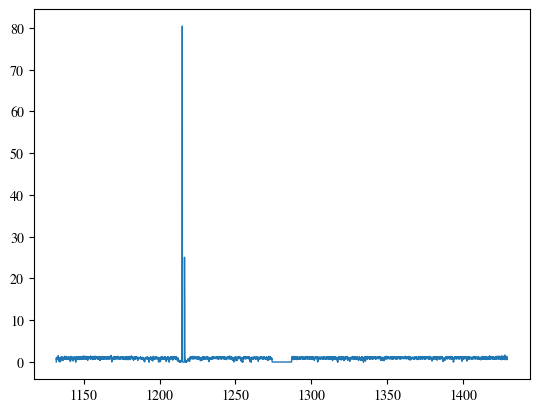

In [466]:
plt.plot(fit_spec['wave'], fit_spec['flux'])

In [467]:
spec_res

'lsf/cos_lsf_g130m_average_lp1-4_yz.txt'

In [468]:
print(dataset.data)

[{'wl': <Column name='wave' dtype='float64' length=9930>
            1132.0
        1132.02991
        1132.05982
        1132.08973
        1132.11964
        1132.14955
        1132.17946
        1132.20937
        1132.23928
        1132.26919
         1132.2991
        1132.32901
               ...
        1428.67729
         1428.7072
        1428.73711
        1428.76702
        1428.79693
        1428.82684
        1428.85675
1428.8866600000001
1428.9165699999999
        1428.94648
        1428.97639, 'flux': <Column name='flux' dtype='float32' length=9930>
       0.0
0.99182266
0.76378524
 0.9013714
0.84164315
0.52158177
0.72604305
0.63620555
 0.6447604
  1.017482
 0.8241821
 0.8881859
       ...
 1.2805374
 0.9751823
 1.1915808
0.91425353
0.79702824
0.91010875
0.76799136
 0.5433506
0.71195716
 0.7618318
 0.9290987, 'error': <Column name='err' dtype='float32' length=9930>
0.049999513
 0.21393172
 0.18911704
 0.20447111
 0.19810267
 0.15889595
 0.18015617
 0.17386322
 0.17500518

In [469]:
print(dataset.lines)

{'HI_1215': <Line: HI  1215.67Å  f=4.16e-01>}


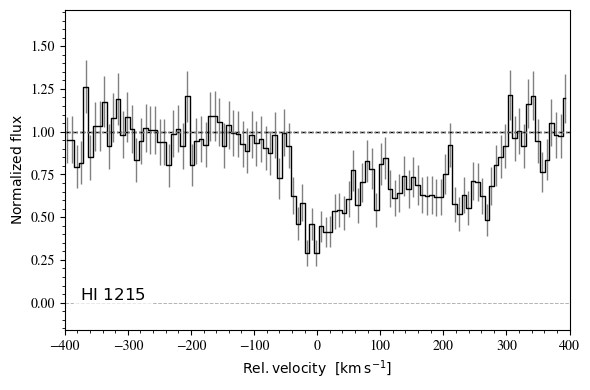

In [470]:
dataset.plot_line('HI_1215')

In [471]:
dataset.prepare_dataset(verbose=True)


 [DONE] - Continuum fitting successfully finished.



 [WARNING]  -  Check-lines is activated
 The following lines of included ions are also covered by the data:

          HI_1 :  f = 4.16e-01



  Dataset is ready to be fitted.



''

In [472]:
for data in dataset.data:
    print(f"Data wavelength range: {min(data['wl'])} - {max(data['wl'])} Å")


Data wavelength range: 1132.0 - 1428.97639 Å


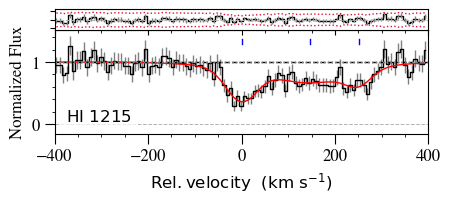

In [473]:
dataset.plot_fit()

In [474]:
dataset.print_total()


-------------------------
  Total Column Densities:
-------------------------

  logN(HI) = 14.461 ± 0.464


In [475]:
dataset.components

{np.str_('HI'): [<Component: z=0.00931  b=25.0  logN=13.6>,
  <Component: z=0.00983  b=10.0  logN=12.7>,
  <Component: z=0.01010  b=10.0  logN=13.2>]}

In [476]:
dataset.show_components()


 -     HI:
    0      -3.0  0.009310     25.0   13.63
    1    +151.5  0.009830     10.0   12.74
    2    +231.7  0.010100     10.0   13.20


In [477]:
dataset.print_results()


----------------------
  Best fit parameters:
----------------------

				b			log(N)
HI  1215
v =  +1.2 ± 4.4             21.37 ±  14.53      14.2357 ±  0.7204
v = +146.9 ± 39.2             82.10 ±  81.69      13.6960 ±  0.3316
v = +250.3 ± 10.0             19.63 ±  32.65      13.5208 ±  0.3182




In [478]:
dataset.print_total()


-------------------------
  Total Column Densities:
-------------------------

  logN(HI) = 14.468 ± 0.462


In [479]:
line_info

A,el,nj,nk,group,name,Ek,f,wrest,Ref,mol,Ej,Am,ion,Ex,Jj,Jk,Z,gk,gj,gamma,Id,species
float64,int64,int64,int64,int64,str7,float64,float64,float64,str10,bytes1,float64,int64,int64,float64,float64,float64,int64,int64,int64,float64,int64,str2
626500000.0,0,0,0,1,HI 1215,2259.163,0.4164,1215.67,Morton2003,--,0.0,0,1,0.0,0.0,0.0,1,6,2,626500000.0,268,HI


In [480]:
param_guess

comp,vmin,vmax,z,v,b,logN
int64,float64,float64,float64,float64,float64,float64
0,-50.0,60.0,0.00931,0.0,25.0,13.63
1,110.0,215.0,0.00983,135.0,10.0,12.738
2,210.0,310.0,0.0101,270.0,10.0,13.195


In [481]:
param_bestfit

comp,ion,z,z_e,b,b_e,logN,logN_e,v,v_e
str5,str2,float64,float64,float64,float64,float64,float64,float64,float64
comp0,HI,0.009324,1.5e-05,21.37,14.53,14.24,0.72,1.2,4.5
comp1,HI,0.009815,0.000132,82.1,81.69,13.7,0.33,148.4,39.57
comp2,HI,0.010163,3.4e-05,19.63,32.65,13.52,0.32,252.73,10.19


In [482]:
tbname

'data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_vfit-param.txt'

In [483]:
dataset.best_fit

name,value,standard error,relative error,initial value,min,max,vary
sid_a8aa15_dvel,0.00000000,0.00000000,,0.0,-inf,inf,False
sid_a8aa15_dlam,0.00000000,0.00000000,,0.0,-5.00000000,5.00000000,False
z0_HI,0.00932395,1.4767e-05,(0.16%),0.00931,-inf,inf,True
b0_HI,21.3687868,14.5257933,(67.98%),25.0,0.00000000,inf,True
logN0_HI,14.2356691,0.72038103,(5.06%),13.63,-inf,inf,True
z1_HI,0.00981452,1.3209e-04,(1.35%),0.00983,-inf,inf,True
b1_HI,82.0963505,81.6889937,(99.50%),10.0,0.00000000,inf,True
logN1_HI,13.6960291,0.33161758,(2.42%),12.738,-inf,inf,True
z2_HI,0.01016268,3.3759e-05,(0.33%),0.0101,-inf,inf,True
b2_HI,19.6259423,32.6546089,(166.38%),10.0,0.00000000,inf,True


In this example, you see that component 2 has very small b (for COS, anything below b<10 is unrealistic; for STIS, b can be smaller), which means we probably don't need this component in the fit. In the following part, we can modify the param_bestfit and redo the fitting until you get a desired result 

# Part 4, Iterative fitting to get better result

In [484]:
# print out param_bestfit and see what need to change
param_bestfit

comp,ion,z,z_e,b,b_e,logN,logN_e,v,v_e
str5,str2,float64,float64,float64,float64,float64,float64,float64,float64
comp0,HI,0.009324,1.5e-05,21.37,14.53,14.24,0.72,1.2,4.5
comp1,HI,0.009815,0.000132,82.1,81.69,13.7,0.33,148.4,39.57
comp2,HI,0.010163,3.4e-05,19.63,32.65,13.52,0.32,252.73,10.19


In [485]:
# SDSSJ142940.73+032125.8

In [486]:
# 2MASXJ14515156+5914001

In [487]:
# UVQSJ170043.71+223700.2

In [488]:
input_tb

comp,vmin,vmax,z,v,b,logN
int64,float64,float64,float64,float64,float64,float64
0,-50.0,60.0,0.00931,0.0,25.0,13.63
1,110.0,215.0,0.00983,135.0,10.0,12.738
2,210.0,310.0,0.0101,270.0,10.0,13.195


In [489]:
### initialize fitting, add data, and add lines
dataset = VoigtFit.DataSet(z_sys) 
dataset.add_data(fit_spec['wave'], fit_spec['flux'], spec_res, err=fit_spec['err'], normalized=True)
for iline in range(len(line_info)): 
    line_name = line_info['name'][iline].replace(' ', '_')
    dataset.add_line(line_name)

### add velocity components based on initial guesses 
for i in range(len(input_tb)): 
    dataset.add_component(ion, input_tb['z'][i], input_tb['b'][i], input_tb['logN'][i])

# Crucial step, prepare and run the fit 
dataset.prepare_dataset(verbose=False)
popt, chi2 = dataset.fit(verbose=False)



 [WARNING]  -  Check-lines is activated
 The following lines of included ions are also covered by the data:

          HI_1 :  f = 4.16e-01



  Fit is running... Please be patient.



<Parameter 'z0_HI', value=np.float64(0.009323950356004864) +/- 1.48e-05, bounds=[-inf:inf]>
1.4766509847692955e-05
<Parameter 'z1_HI', value=np.float64(0.009814523848462799) +/- 0.000132, bounds=[-inf:inf]>
0.0001320928476983682
<Parameter 'z2_HI', value=np.float64(0.010162680101800214) +/- 3.38e-05, bounds=[-inf:inf]>
3.375920233000477e-05
Saving best fit parameters to:  data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_vfit-param.txt
Saving HI 1215 to:  data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_voigt-1215.txt
Figure saved to:  data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_vfit.pdf
Saving input table to: data/UVQSJ170043.71+223700.2/UVQSJ170043.71+223700.2_final-input.txt


comp,ion,z,z_e,b,b_e,logN,logN_e,v,v_e
str5,str2,float64,float64,float64,float64,float64,float64,float64,float64
comp0,HI,0.009324,1.5e-05,21.37,14.53,14.24,0.72,1.2,4.5
comp1,HI,0.009815,0.000132,82.1,81.69,13.7,0.33,148.4,39.57
comp2,HI,0.010163,3.4e-05,19.63,32.65,13.52,0.32,252.73,10.19


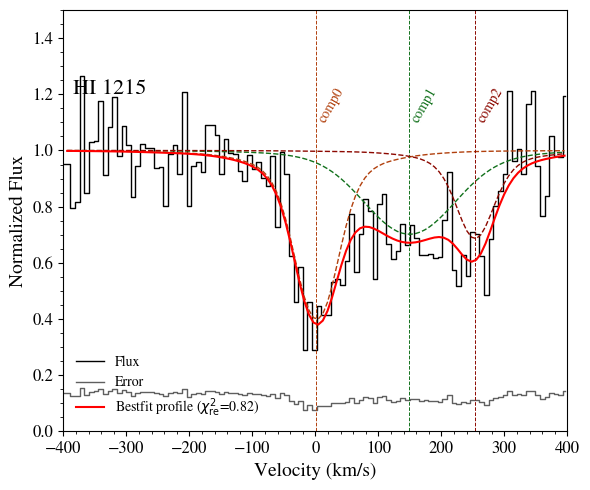

In [490]:
# record the result and plot individual components
figname = spec_file.replace('_ltnorm.fits', '_vfit.pdf')
tbname = spec_file.replace('_ltnorm.fits', '_vfit-param.txt')
vpname = spec_file.replace('_ltnorm.fits', '.fits')
itname = spec_file.replace('_ltnorm.fits', '_final-input.txt')

# from voigtfit_mod import reproduce_individual_voigt_profile
param_bestfit = parse_output_to_astropy_table(ion, dataset.best_fit, popt, tbname=tbname, z_sys=z_sys)
voigt_files = reproduce_voigt_profile(line_info, param_bestfit, fit_spec['wave'], spec_res, vpname, z_sys=z_sys)
plot_fit_result(line_info, voigt_files, fit_spec, param_bestfit, vmin=fit_vmin, vmax=fit_vmax,gal_vsys=gal_vsys,figname=figname)

ascii.write(input_tb, itname, format='fixed_width', delimiter=',', overwrite=True)
print("Saving input table to:", itname)

param_bestfit

In [491]:
for row in param_bestfit:
    print(str(row['z'])+'\t'+str(row['logN'])+'\t'+str(row['logN_e'])+'\t'+str(row['b'])+'\t'+str(row['b_e'])+'\t'+str(row['v'])+'\t'+str(row['v_e']))

0.009324	14.24	0.72	21.37	14.53	1.2	4.5
0.009815	13.7	0.33	82.1	81.69	148.4	39.57
0.010163	13.52	0.32	19.63	32.65	252.73	10.19


In [492]:
dataset.print_total()


-------------------------
  Total Column Densities:
-------------------------

  logN(HI) = 14.470 ± 0.469


Saving best fit parameters to:  data/sk-70d115/hlsp_ullyses_hst_stis_sk-70d115_e140m_dr7_cspec-s-ii_vfit-param.txt
Saving SII 1250 to:  data/sk-70d115/hlsp_ullyses_hst_stis_sk-70d115_e140m_dr7_cspec-s-ii_voigt-1250.txt
Saving SII 1253 to:  data/sk-70d115/hlsp_ullyses_hst_stis_sk-70d115_e140m_dr7_cspec-s-ii_voigt-1253.txt
Figure saved to:  data/sk-70d115/hlsp_ullyses_hst_stis_sk-70d115_e140m_dr7_cspec-s-ii_vfit.pdf


comp,ion,z,z_e,b,b_e,logN,logN_e,v,v_e
str5,str3,float64,float64,float64,float64,float64,float64,float64,float64
comp0,SII,6e-05,1e-06,10.89,0.58,15.79,0.07,17.99,0.3
comp1,SII,0.000764,1e-06,8.76,0.61,15.52,0.06,229.04,0.3
comp2,SII,0.000872,3e-06,10.74,2.1,14.79,0.04,261.42,0.9
comp3,SII,0.000987,3e-06,9.72,1.12,15.62,0.06,295.9,0.9
comp4,SII,0.001077,3e-06,10.53,1.0,15.4,0.04,322.88,0.9


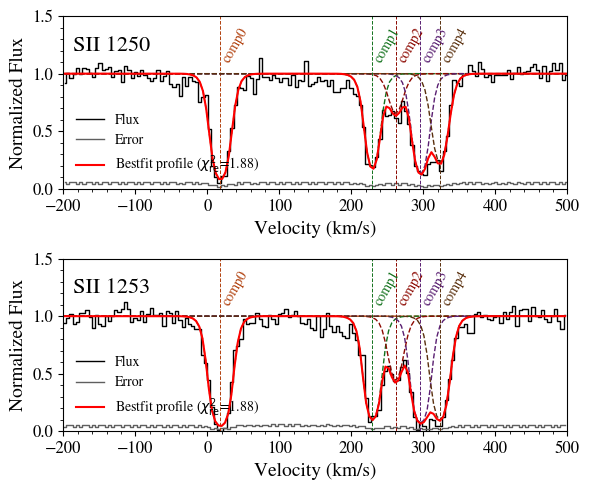

In [24]:
# record the result and plot individual components
figname = spec_file.replace('.fits', '_vfit.pdf')
tbname = spec_file.replace('.fits', '_vfit-param.txt')

# from voigtfit_mod import reproduce_individual_voigt_profile
param_bestfit = parse_output_to_astropy_table(ion, dataset.best_fit, popt, tbname=tbname, z_sys=z_sys)
voigt_files = reproduce_voigt_profile(line_info, param_bestfit, fit_spec['wave'], spec_res, spec_file, z_sys=z_sys)
plot_fit_result(line_info, voigt_files, fit_spec, param_bestfit, vmin=fit_vmin, vmax=fit_vmax,figname=figname)
param_bestfit